In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC



### Загрузите датасет breast_cancer.


In [2]:
data = load_breast_cancer()

In [3]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

### Выберите два первых признака. Таким образом мы уменьшим размерность задачи. У нас была задача множественной классификации, а стала - бинарная.


In [4]:
x = data.data[:,:2]
y = data.target

print(x)

[[17.99 10.38]
 [20.57 17.77]
 [19.69 21.25]
 ...
 [16.6  28.08]
 [20.6  29.33]
 [ 7.76 24.54]]


### Разделите датасет на обучающую и тестовую выборки в пропорции 80-20.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)


In [6]:
X_train.shape

(455, 2)

In [7]:
X_test.shape

(114, 2)

### Постройте классификатор на опорных векторах с гауссовым ядром с параметром регуляризации C=0.01. Выведите на экран значение точности на тестовой и обучающей выборке. Сделайте предварительный вывод о степени обученности модели.


In [8]:
clf = SVC(C=0.01)
 
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

err_train = np.mean(y_train != clf.predict(X_train))
err_test = np.mean(y_test != clf.predict(X_test))
 
print('\033[1m Train score:\033[0m',round(clf.score(X_train, y_train),2),' \033[1m Test score:\033[0m',round(clf.score(X_test, y_test),2))
print('\033[1m Train error:\033[0m',round(err_train,2),' \033[1m Test error:\033[0m', round(err_test,2))


 Train score: 0.71   Test score: 0.69
 Train error: 0.29   Test error: 0.31


Если смотреть на ошибку для обучающей и тренировочной выборки, а так же на метрику score, то мы видим, что модель не очень хорошо работает как на обучающей, так и на тренировочной выборке, что может говорить о **недообучении**

### Постройте графически зависимость тестовой и обучающей точности от размера обучающей выборки.

##### Прокомментируйте получившийся результат. Сделайте вывод о том, недообучается или переобучается модель? 

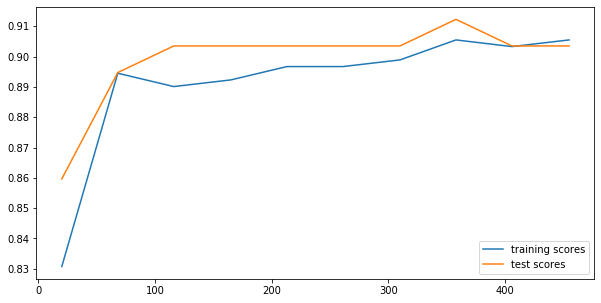

In [9]:
training_scores = []
test_scores = []
numbers = []
 
for i in np.linspace(20, len(X_train), 10):
    
    clf = SVC(C=10, kernel='rbf')
    X = X_train[:int(i)]
    y = y_train[:int(i)]
    clf.fit(X, y)
    
    numbers.append(int(i))
    training_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
    
plt.figure(figsize=(10, 5))
plt.plot(numbers, training_scores, label="training scores")
plt.plot(numbers, test_scores, label="test scores")
plt.legend(loc="lower right")


Видно, что обучающая выборка резко улучшает свой показатель к объему выборки ~150, а дальше стабилизируетсяя и равна около 0,9

Тестовая выборка постепенно улучшает свой показатель, но после ~350 резко ухудшает, и дальше возможно при увеличении объема модель станет переобученной

В виду этого можно сделать вывод, что модель в интервале с 100 до 350 по оси Х с увеличением объема улучшает результат работы модели, что значит, что данная модель дообучается, будучи изначально **недообученной**

#### В зависимости от этого выберите варианты, которые могут привести к увеличению точности модели (обычно подходит больше одного варианта):


* __Ответ:__ можно попробовать собрать больше объектов наблюдения или добавить еще признаков для обучения, также можно попробовать  усложнить модель, либо поработать с методами регуляризации модели



### Проверьте выдвинутую гипотезу и попробуйте улучшить модель в соответствии с выбранными рекомендациями. Проверьте, увеличивается ли тестовая точность. Сделайте вывод.


_Попробуем добавить признаки в модель, которые могут как-то помочь определять болезнь_

Для этого изучим доступные признаки и выберем те, которые по логике могут быть ключевымит в опредлении модели

Используем метод hierarchy,который боретчя с мультиколлениарностью

In [10]:
print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Можно оценить влияние каждого признака на target

In [11]:
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(426, 30)

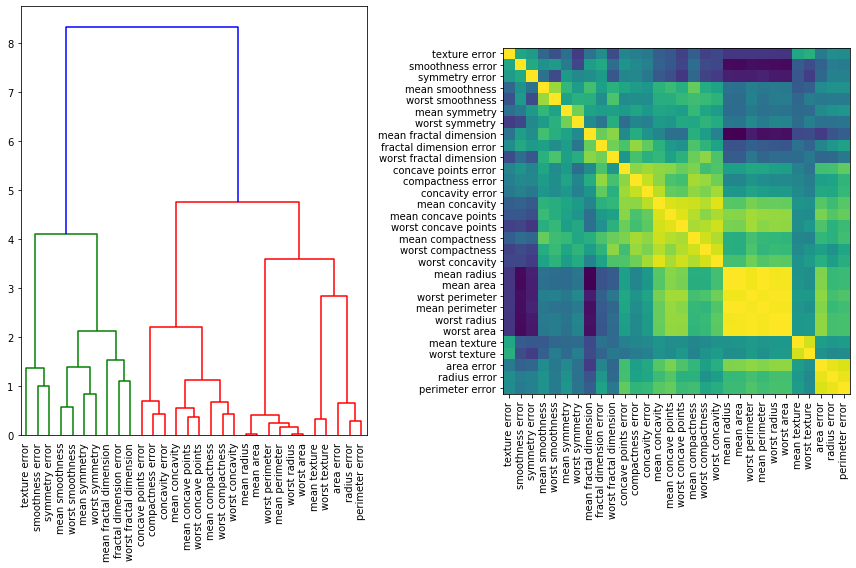

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

    С помощью построения тепловой карты корреляицонных функций фич мы можем понять, наиболее кореллирующие фичи с объектом, также на левом графике происходит кластеризации функций, чтобы понять какие можно убрать без потери качества модели, а какие точно нужно включить из-за своей важности

Возьмем например, к имеющимся ранее признакам еще признак worst concave points и mean area и посмотрим, как изменилось качество модели

In [13]:
X = data.data
df = pd.DataFrame(data=data.data,columns=data.feature_names)
X = df[['mean radius', 'mean texture', 'mean area', 'worst concave points']]
y = data.target

In [14]:
X.head()

,mean radius,mean texture,mean area,worst concave points
0,17.99,10.38,1001.0,0.2654
1,20.57,17.77,1326.0,0.1860
2,19.69,21.25,1203.0,0.2430
3,11.42,20.38,386.1,0.2575
4,20.29,14.34,1297.0,0.1625


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

In [16]:
X_train.head()

,mean radius,mean texture,mean area,worst concave points
190,14.22,23.12,609.9,0.17720
134,18.45,21.91,1075.0,0.13790
386,12.21,14.09,462.0,0.09140
118,15.78,22.91,782.6,0.20340
316,12.18,14.08,461.4,0.01852


In [17]:
X_train.shape

(455, 4)

In [18]:
clf = SVC(C=0.01)
 
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

err_train = np.mean(y_train != clf.predict(X_train))
err_test = np.mean(y_test != clf.predict(X_test))
 
print('\033[1m Train score:\033[0m',round(clf.score(X_train, y_train),2),' \033[1m Test score:\033[0m',round(clf.score(X_test, y_test),2))
print('\033[1m Train error:\033[0m',round(err_train,2),' \033[1m Test error:\033[0m', round(err_test,2))



 Train score: 0.8   Test score: 0.75
 Train error: 0.2   Test error: 0.25


Как мы видим, увеличилась метрика score и уменьшилась ошибка как на тренировчной выборке, так и на тестовой

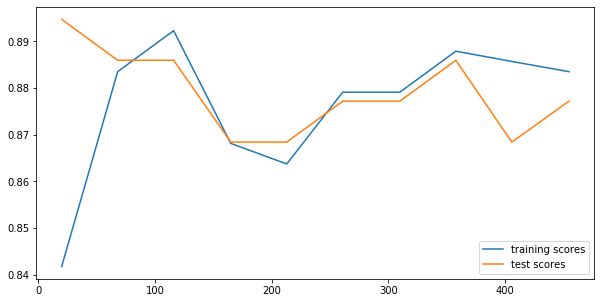

In [19]:
training_scores = []
test_scores = []
numbers = []
 
for i in np.linspace(20, len(X_train), 10):
    
    clf = SVC(C=10, kernel='rbf')
    X = X_train[:int(i)]
    y = y_train[:int(i)]
    clf.fit(X, y)
    
    numbers.append(int(i))
    training_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
    
plt.figure(figsize=(10, 5))
plt.plot(numbers, training_scores, label="training scores")
plt.plot(numbers, test_scores, label="test scores")
plt.legend(loc="lower right")



Есть объемы выборки, когда модель является переобученной, а есть когда недообученной, но в целом точность модели поывысилась, как на обучающей, так и на тестовой выборке

### Повторите предыдущий пункт для различных значений C в диапазоне от 0,0001 до 1 000 000. Обратите внимание на шкалу по вертикальной оси. Для каких значений тестовая точность оптимальна? Какие значения дают недообучение? Какие - переобучение?


### Найдите методом подбора оптимальное значение параметра регуляризации (примерное).


In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
estimator = SVC()
grid_svc =GridSearchCV(estimator,
             param_grid={'C': [0.0001, 1000000]})
grid_svc.fit(X_train,y_train)
predicted = grid_svc.predict(X_test)

In [22]:
print('\033[1m Train score:\033[0m',round(grid_svc.score(X_train, y_train),2),' \033[1m Test score:\033[0m',round(grid_svc.score(X_test, y_test),2))

 Train score: 0.94   Test score: 0.95


In [23]:
grid_svc.best_params_

{'C': 1000000}

In [24]:
scores_test = []
scores_train = []
cs =np.arange(0.01, 1000000, 10000)
for i in cs:
    clf = SVC(C=i)
    clf.fit(X_train,y_train)
    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))
    
print(len(cs))    

100


#### Постройте график зависимости тестовой и обучающей точности от значения регуляризационного параметра. Сделайте вывод о зависимости степени регуляризации на точность модели.


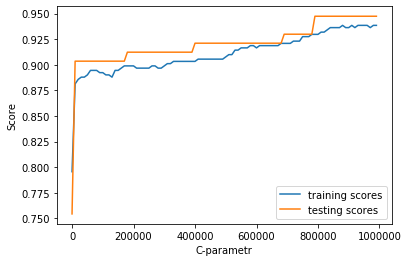

In [25]:
plt.plot(cs,scores_train,label="training scores")
plt.plot(cs,scores_test,label="testing scores")
plt.ylabel('Score')
plt.xlabel('C-parametr')
plt.legend(loc="lower right")

Методом грид серча подобрался самый лучший параметр из предложенного диапазона и он равен 1000000

Как видно на графике, до какого-то параметра С линия тестовой выборки ниже тренировчной, что говорит о переобучении, далее алгоритм улучшает свой показатель и убирает переобучение

### Повторите два предыдущих пункта для метода опорных векторов с линейным ядром. Сравните получившиеся результаты. Сделайте вывод о сравнительной эффективности двух этих моделей.


In [26]:
linear_svc = SVC(kernel='linear')
linear_svc.fit(X_train, y_train)

predicted = linear_svc.predict(X_test)

err_train = np.mean(y_train != linear_svc.predict(X_train))
err_test = np.mean(y_test != linear_svc.predict(X_test))
 
print('\033[1m Train score:\033[0m',round(linear_svc.score(X_train, y_train),2),' \033[1m Test score:\033[0m',round(linear_svc.score(X_test, y_test),2))
print('\033[1m Train error:\033[0m',round(err_train,2),' \033[1m Test error:\033[0m', round(err_test,2))




 Train score: 0.91   Test score: 0.9
 Train error: 0.09   Test error: 0.1


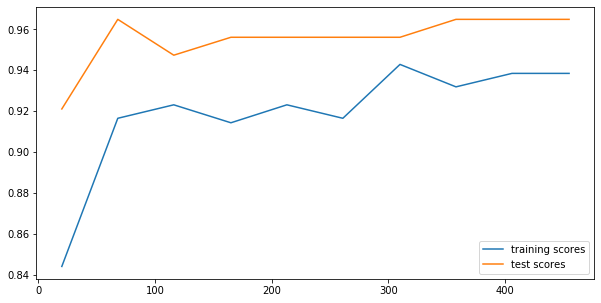

In [27]:
training_scores = []
test_scores = []
numbers = []
 
for i in np.linspace(20, len(X_train), 10):
    
    clf = SVC(C=10, kernel='linear')
    X = X_train[:int(i)]
    y = y_train[:int(i)]
    clf.fit(X, y)
    
    numbers.append(int(i))
    training_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
    
plt.figure(figsize=(10, 5))
plt.plot(numbers, training_scores, label="training scores")
plt.plot(numbers, test_scores, label="test scores")
plt.legend(loc="lower right")



По сравнению с rbf-ядром линейная svc модель показывает меньшую разницу между тестовым и тренировочным показателем, и в целом у данной модели ошибка для обоих выборок меньше, чем в предыдущей модели

Тем не менее мы видим на графике, что сначала модель хорошо обучена, а дальше происходит спад показателя для тестовой выборки в сравнении с тренировчной, то есть модель становится переобученной

In [28]:
estimator = SVC(kernel='linear')
grid_svc =GridSearchCV(estimator,
             param_grid={'C': [0.0001, 1000000]})
grid_svc.fit(X_train,y_train)
predicted = grid_svc.predict(X_test)

In [29]:
print('\033[1m Train score:\033[0m',round(grid_svc.score(X_train, y_train),2),' \033[1m Test score:\033[0m',round(grid_svc.score(X_test, y_test),2))

 Train score: 0.95   Test score: 0.96


In [30]:
grid_svc.best_params_

{'C': 1000000}

In [31]:
scores_test = []
scores_train = []
cs =np.arange(0.01, 100000, 5000)
for i in cs:
    clf = SVC(C=i, kernel='linear')
    clf.fit(X_train,y_train)
    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))
    
print(len(cs))    

20


#### Постройте график зависимости тестовой и обучающей точности от значения регуляризационного параметра. Сделайте вывод о зависимости степени регуляризации на точность модели.


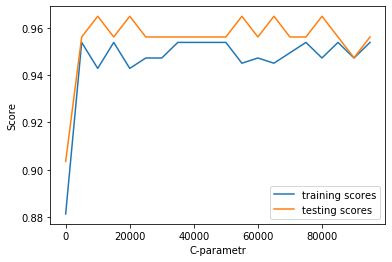

In [32]:
plt.plot(cs,scores_train,label="training scores")
plt.plot(cs,scores_test,label="testing scores")
plt.ylabel('Score')
plt.xlabel('C-parametr')
plt.legend(loc="lower right")

Как видно на графике, для данного метода С-параметр не  влияет на обученность модели: на протяжении всей оси Х прямая тестовой выборки ниже тренировчной, то есть ее показатель хуже, чем у тренировочной, а значит можно предположить, что модель переобучена во всех случаях параметра С

В одной точке даже есть, где модель переобчена сильнее всего - это низкий спуск на графике линии тестовой выборки

Но несмотря, что на графике видна тенденция переобученности модели, ее показатель варьируется в пределах 90%, что является самим по себе неплохим результатом для модели

## Дополнительные задания


### Повторите такой же анализ для полиномиального ядра и степени полинома как гиперпараметра. Прокомментируйте кривые обучения для случаев недо-и переобучения.

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

In [34]:
poly_reg = PolynomialFeatures(degree=2)
X_pol_train = poly_reg.fit_transform(X_train)
X_pol_test = poly_reg.fit_transform(X_test)
    
pol_reg = SVC(kernel='rbf')
test=pol_reg.fit(X_pol_train, y)
Y_pred = pol_reg.predict(X_pol_test)
    
print(pol_reg.score(X_pol_train,y_train))

0.8637362637362638


In [35]:
score = []
score_test = []
degrees = [1,2,3,4,5,6,7,8,9,10]
for degree in degrees:
    poly_reg = PolynomialFeatures(degree=degree)
    X_pol_train = poly_reg.fit_transform(X_train)
    X_pol_test = poly_reg.fit_transform(X_test)
    
    pol_reg = SVC(kernel='rbf')
    test=pol_reg.fit(X_pol_train, y)
    Y_pred = pol_reg.predict(X_pol_test)
    
    score.append(pol_reg.score(X_pol_train,y_train))
    score_test.append(pol_reg.score(X_pol_test,y_test))

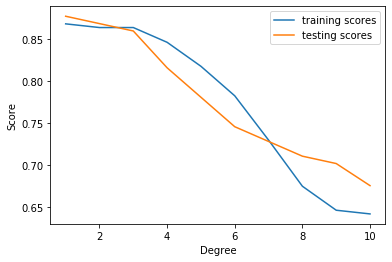

In [36]:
plt.plot(degrees,score,label="training scores")
plt.plot(degrees,score_test,label="testing scores")
plt.ylabel('Score')
plt.xlabel('Degree')
plt.legend(loc="upper right")

Как мы видим, модель становится переобученной, чем выше степень в полиномиальной регрессии

При степени 2 модель показывает для тестовой выборки результат лучше, чем для тренировчной, что говорит о самом оптимальном гиперпараметре среди всех, тем не менее даже при самой оптимальной степени в полиномиальной регресси, показатель метрики хуже, чем при простом методе svc

### Исследуйте зависимость степени обученности модели от значения других гиперпараметров различных классификаторов, реализованных в sklearn. Постройте кривые обучения в зависимости от значения этих параметров.


Возьмем модель LogisticRegression

In [37]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [38]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
predicted = lr.predict(X_test)

err_train = np.mean(y_train != lr.predict(X_train))
err_test = np.mean(y_test != lr.predict(X_test))
 
print('\033[1m Train score:\033[0m',round(lr.score(X_train, y_train),2),' \033[1m Test score:\033[0m',round(lr.score(X_test, y_test),2))
print('\033[1m Train error:\033[0m',round(err_train,2),' \033[1m Test error:\033[0m', round(err_test,2))



 Train score: 0.89   Test score: 0.91
 Train error: 0.11   Test error: 0.09


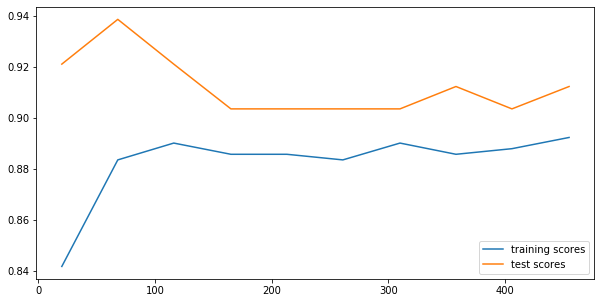

In [40]:
training_scores = []
test_scores = []
numbers = []
 
for i in np.linspace(20, len(X_train), 10):
    
    clf = LogisticRegression()
    X = X_train[:int(i)]
    y = y_train[:int(i)]
    clf.fit(X, y)
    
    numbers.append(int(i))
    training_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
    
plt.figure(figsize=(10, 5))
plt.plot(numbers, training_scores, label="training scores")
plt.plot(numbers, test_scores, label="test scores")
plt.legend(loc="lower right")

Смотря на график, мы видим, что сначала модель недообучена, так как для тестовой выборки показатель хуже, чем для тренировочной. Далее при увеличении объема выборки  и до объема ~350 выборка хорошая, так как результат для тестовой выборки лучше тренировочной, а потом опять модель ухудшается, но становится переобученной

In [41]:
scores_test = []
scores_train = []
cs =np.arange(0.001, 10, 0.005)
for i in cs:
    clf = LogisticRegression(C= i, max_iter=1000)
    clf.fit(X_train,y_train)
    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))
    
#print(scores_test)    

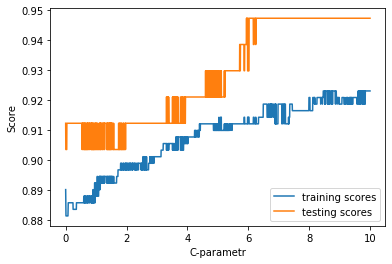

In [42]:
plt.plot(cs,scores_train,label="training scores")
plt.plot(cs,scores_test,label="testing scores")
plt.ylabel('Score')
plt.xlabel('C-parametr')
plt.legend(loc="lower right")

Настолько нестабильный график говорит о том, что качество модели очень зависит от оптимального параметра С: переобучение вначале, а потом при увеличении праметра С модель иногда обучается нормально; подходящий параметр С  подобрать можно с помощью GridSearch

In [43]:
parameters = { 'C': (10, 1e-5) }



gs_clf = GridSearchCV(lr, parameters, n_jobs=-1, cv=6)
gs_clf = gs_clf.fit(X_train,y_train)


In [44]:
gs_clf.score(X_train,y_train)

0.9230769230769231

### Повторите данное исследование на полном датасете. Сделайте выводы об оптимальной регулризации моделей.


In [45]:
x = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [46]:
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)

In [47]:
err_train = np.mean(y_train != clf.predict(X_train))
err_test = np.mean(y_test != clf.predict(X_test))
 
print('\033[1m Train score:\033[0m',round(clf.score(X_train, y_train),2),' \033[1m Test score:\033[0m',round(clf.score(X_test, y_test),2))
print('\033[1m Train error:\033[0m',round(err_train,2),' \033[1m Test error:\033[0m', round(err_test,2))

 Train score: 0.97   Test score: 0.96
 Train error: 0.03   Test error: 0.04


Полный датасет одним и тем же методом обучения точнее нежели, чем такая же модель с уменьшенным количеством признаков. А значит, что были отброшены важные фичи для обучения

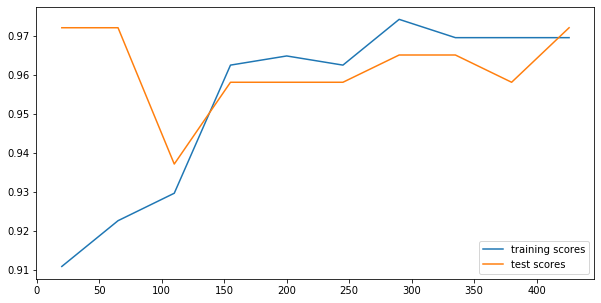

In [48]:
training_scores = []
test_scores = []
numbers = []
 
for i in np.linspace(20, len(X_train), 10):
    
    clf = SVC(C=5, kernel='linear')
    X = X_train[:int(i)]
    y = y_train[:int(i)]
    clf.fit(X, y)
    
    numbers.append(int(i))
    training_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
    
plt.figure(figsize=(10, 5))
plt.plot(numbers, training_scores, label="training scores")
plt.plot(numbers, test_scores, label="test scores")
plt.legend(loc="lower right")



Как видно на графике, в зависимости от выборки меняется метрика качества: в начале модель являет переобученной, так как метрика качества тестовой выборки слишком хуже, чем тренировочная, а вот при увеличении объема выборки модель улучшает свою производительность

#### Выведем коэффициенты перед признаками

In [49]:
coefs = clf.coef_
names = data.feature_names


for i in zip(names,coefs[0]):
    print(' -  '.join(map(lambda x: str(x),i)))

mean radius -  2.58582980198436
mean texture -  0.09724835427403278
mean perimeter -  -0.5272891171965313
mean area -  0.018928269641378392
mean smoothness -  -0.47961708794138147
mean compactness -  -0.5095376004005503
mean concavity -  -1.6224749127527343
mean concave points -  -1.071893269076559
mean symmetry -  -0.8324943735395004
mean fractal dimension -  -0.08063824264259956
radius error -  -0.5805769841516797
texture error -  2.9603739074017814
perimeter error -  0.6448634684948549
area error -  -0.17871771129038194
smoothness error -  -0.08929839201329207
compactness error -  0.2400856712846136
concavity error -  -0.12978124120907722
concave points error -  -0.10048912360334741
symmetry error -  -0.16027536742861415
fractal dimension error -  0.04627972804774737
worst radius -  0.6035643779879685
worst texture -  -0.4656859958314996
worst perimeter -  0.07009134191994804
worst area -  -0.01991177341267303
worst smoothness -  -1.0494616528960001
worst compactness -  -0.753115549

Есть коэффициенты, веса перед которыми очень малы, давайте попробуем с помощью алгоритма l1 (lasso) провести регуляризацию для определения весов для более точной модели

In [50]:
from sklearn.linear_model import Lasso

In [51]:
lasso = Lasso(random_state=0, max_iter=40000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


Text(0.5, 0, 'alpha')

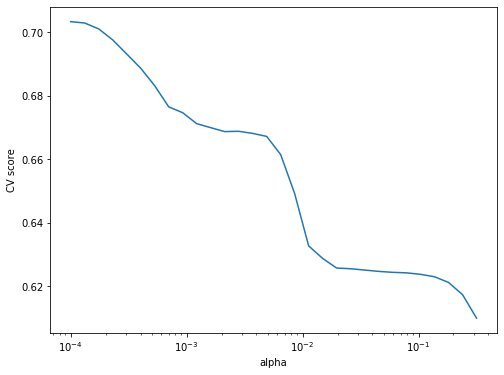

In [52]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)



plt.ylabel('CV score')
plt.xlabel('alpha')


In [53]:
clf.best_params_

{'alpha': 0.0001}

In [54]:
clf.best_score_

0.7033404906920737

Как мы видим, при использовании всех признаков (то есть полного датасета) ухудшается качество модели, самая лучшая модель получается при alpha=0.0001

### Сделайте выводы об оптимальной регулризации моделей.


Никогда нельзя знать наверняка, что нужно изменить для оптимальной регуляризации модели. Это может быть даже не одно действие, так что надо пробовать перебирать возможные способы для того, чтоьбы улучшить модель